In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from transformers import pipeline
from collections import Counter
import re
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import pipeline, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
data = pd.read_csv("dataset.csv")

In [4]:
data['Foundation'] = None

In [5]:
data.head()

,Corpus,Tweet Text,Stance,Foundation
0,EVM,#EVMs are easy to manipulate . This was demons...,1,None
1,CAA,Congratulations Aa gya #CAA,1,None
2,CAA,My dear Indian muslims we are 35 crores of pop...,-1,None
3,CAA,This guy was part of anti Hindu protests in th...,1,None
4,CAA,Woman protester breaks down while speaking to ...,0,None


In [6]:
class_counts = data.iloc[:, 0].value_counts()

print("Number of rows for each class:")
print(class_counts)

total_rows = data.shape[0]
print("\nTotal number of rows:", total_rows)

Number of rows for each class:
Corpus
CAA                     207
UCC                     190
EVM                     181
LGBTQ                   172
Animal Sacrifices       166
Anti Conversion Laws    162
Brain Drain             148
Name: count, dtype: int64

Total number of rows: 1226


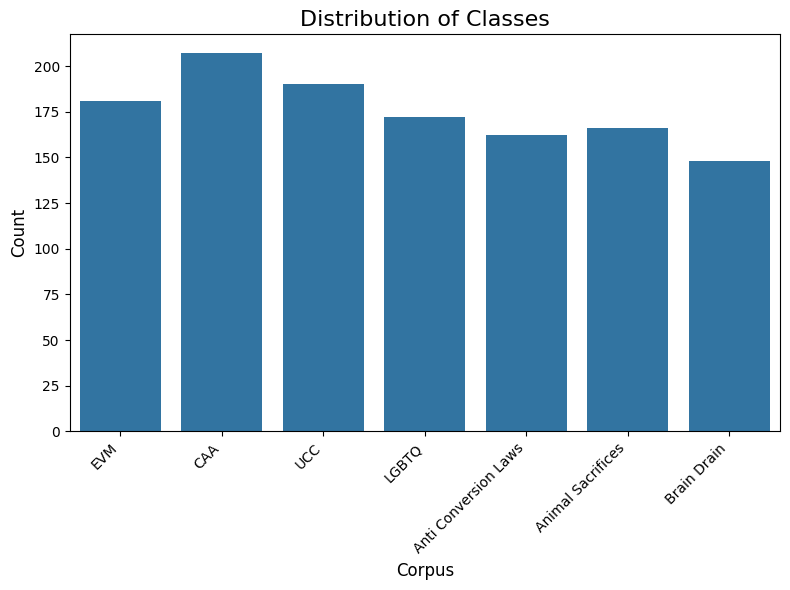

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Corpus', data=data)
plt.title('Distribution of Classes', fontsize=16)
plt.xlabel('Corpus', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  
plt.tight_layout()
plt.show()

In [8]:
def clean_tweet(tweet):
    tweet = re.sub(r'@[\w_]+', '', tweet)  
    tweet = re.sub(r'#\w+', '', tweet)     
    tweet = re.sub(r'http\S+|www\S+', '', tweet)  
    tweet = re.sub(r'[^A-Za-z0-9\s]+', '', tweet) 
    tweet = tweet.strip().lower()
    return tweet

In [10]:

data['cleaned_tweet'] = data['Tweet Text'].apply(clean_tweet)

In [11]:
data.head()

,Corpus,Tweet Text,Stance,Foundation,cleaned_tweet
0,EVM,#EVMs are easy to manipulate . This was demons...,1,None,are easy to manipulate this was demonstrated ...
1,CAA,Congratulations Aa gya #CAA,1,None,congratulations aa gya
2,CAA,My dear Indian muslims we are 35 crores of pop...,-1,None,my dear indian muslims we are 35 crores of pop...
3,CAA,This guy was part of anti Hindu protests in th...,1,None,this guy was part of anti hindu protests in th...
4,CAA,Woman protester breaks down while speaking to ...,0,None,woman protester breaks down while speaking to ...


### Zero Shot predictions for initial prdictions
####     -Using hugging face bart-large-mnli model for making predictions
####     -Classifying a total of 15% of the total tweets 

In [14]:
#classifier
classifier = pipeline("zero-shot-classification", model = "facebook/bart-large-mnli",device = 0)


Device set to use cuda:0


In [15]:
#data seg
zero_samples = data.sample(frac=0.15, random_state=42)
moral_foundations = ["Care", "Fairness", "Loyalty", "Authority", "Liberty"]


In [16]:
# Select threshold for final multi-label classification
final_threshold = 0.3
all_predicted_labels = []
d = dict()
for text in zero_samples["Tweet Text"]:
    result = classifier(text, moral_foundations)
    
    # Append selected labels
    selected_labels = [label for label, score in zip(result["labels"], result["scores"]) if score >= final_threshold]
    d[text] = tuple(selected_labels)
    all_predicted_labels.extend(selected_labels)

# Count label occurrences
label_counts = Counter(all_predicted_labels)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [17]:
len(all_predicted_labels)

171

In [18]:
len(zero_samples["Tweet Text"])

184

In [19]:
print(d)

{"How does someone's marriage affect your life? Mind your business.": ('Care',), 'Is the CAA solving a problem or creating new ones? This needs deeper thought.': ('Authority', 'Care'), 'Instead of protecting, these laws are dividing communities.': (), 'Successful Indians abroad inspire the next generation.': ('Care',), 'Healthcare systems lose skilled workers to better opportunities abroad. Strengthen infrastructure to reverse the flow. #Brain Drain': ('Care',), "Rhonda Fleming is suing her warden for forcing her to undress around trans-ID men. \n\nI wrote about that and her other righteous legal battles. I also interviewed her lawyer, learned about Alliance Defending Freedom's role, and discovered that Chase Strangio is to blame for everything.": ('Care',), 'The grass is greener where opportunities are. Let’s focus on India.': ('Care',), 'Can we call ourselves secular if we exclude certain groups from justice?': ('Care',), "Migration isn't a choice; it's a necessity when local options

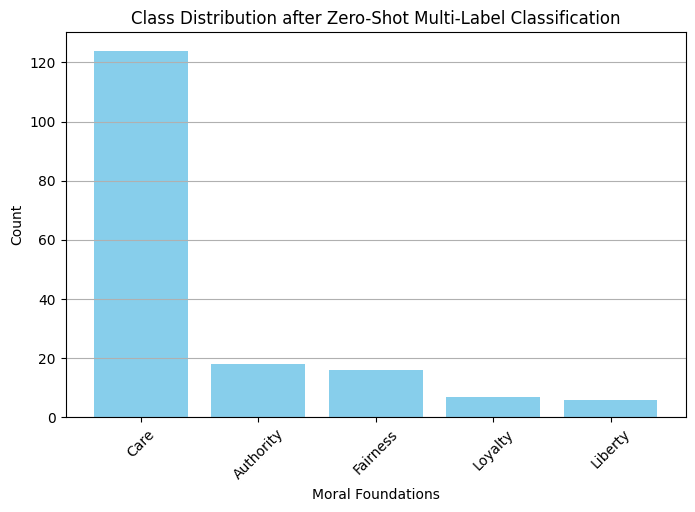

In [20]:
# Plot label counts vs threshold
plt.figure(figsize=(8, 5))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.title("Class Distribution after Zero-Shot Multi-Label Classification")
plt.xlabel("Moral Foundations")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [23]:
# from transformers import pipeline

# # Load the zero-shot classification pipeline
# classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# text = "Helping the poor is a moral duty."
# candidate_labels = ["Care", "Fairness", "Loyalty", "Authority", "Sanctity", "Liberty"]

# # Perform zero-shot classification
# result = classifier(text, candidate_labels)
# print(result)


Device set to use cuda:0


{'sequence': 'Helping the poor is a moral duty.', 'labels': ['Care', 'Liberty', 'Sanctity', 'Fairness', 'Authority', 'Loyalty'], 'scores': [0.587022066116333, 0.0967930257320404, 0.0940442755818367, 0.08720043301582336, 0.07743038237094879, 0.05750971660017967]}


## Few Shot learing
###     -Creating a data Farme of Zero shot labels and feeding them to compute few shot prediction

In [21]:
#data frame creation
few_shot_data = pd.DataFrame({
    "text": list(d.keys()),
    "labels":list(d)
})

In [22]:
few_shot_data.head()

,text,labels
0,How does someone's marriage affect your life? ...,How does someone's marriage affect your life? ...
1,Is the CAA solving a problem or creating new o...,Is the CAA solving a problem or creating new o...
2,"Instead of protecting, these laws are dividing...","Instead of protecting, these laws are dividing..."
3,Successful Indians abroad inspire the next gen...,Successful Indians abroad inspire the next gen...
4,Healthcare systems lose skilled workers to bet...,Healthcare systems lose skilled workers to bet...


In [23]:
#creating encodings
mlb = MultiLabelBinarizer(classes=moral_foundations)
labels = mlb.fit_transform(few_shot_data['labels'])



/home/anurag/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['\n', ' ', '!', '"', '#', '%', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '—', '‘', '’', '“', '”'] will be ignored
  warnings.warn(


In [24]:
#tokenizing the text
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
inputs = tokenizer(list(few_shot_data["text"]), padding = True, truncation = True, return_tensors = "pt")

### Creating a data pipeline

In [25]:
#model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = len(moral_foundations))
model.to('cuda')
#labels to torch tensors
torch_labels = torch.tensor(labels, dtype = torch.float)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
#training args
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
)

/home/anurag/.local/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [27]:
#dataset
class TweetData(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

In [28]:
#initializing the data set
dataset = TweetData(inputs, torch_labels)

In [29]:
#setting the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

In [30]:
#training
trainer.train()

/tmp/ipykernel_94/111473958.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss


TrainOutput(global_step=115, training_loss=0.16590017235797386, metrics={'train_runtime': 15.2948, 'train_samples_per_second': 60.151, 'train_steps_per_second': 7.519, 'total_flos': 35932071330240.0, 'train_loss': 0.16590017235797386, 'epoch': 5.0})

### predictions from the few shot model

In [31]:
#dropping the data used for zero shot prediction
remain_tweets = data.drop(zero_samples.index)["Tweet Text"]

#tokenizing the text
test_inputs = tokenizer(list(remain_tweets), padding=True, truncation= True, return_tensors = "pt")

# Batch size for prediction
batch_size = 32  # Adjust this value based on your GPU memory

# Perform predictions in batches
all_predictions = []
for i in range(0, len(remain_tweets), batch_size):
    batch_inputs = {k: v[i:i + batch_size].to('cuda') for k, v in test_inputs.items()}
    with torch.no_grad():  # Disable gradient calculation during prediction
        batch_predictions = model(**batch_inputs)
    all_predictions.append(batch_predictions.logits) # Store only the logits

# Concatenate predictions from all batches
all_predictions = torch.cat(all_predictions, dim=0)

In [43]:
# Get predicted probabilities and labels
predicted_probs = torch.sigmoid(all_predictions)
predicted_labels = [[moral_foundations[i] for i, p in enumerate(probs) if p > 0.053] for probs in predicted_probs.cpu()] # Move probs to CPU before iterating

In [37]:
print(predicted_probs)

tensor([[0.0434, 0.0507, 0.0562, 0.0536, 0.0472],
        [0.0556, 0.0459, 0.0545, 0.0671, 0.0576],
        [0.0515, 0.0491, 0.0597, 0.0483, 0.0450],
        ...,
        [0.0544, 0.0511, 0.0574, 0.0473, 0.0515],
        [0.0594, 0.0468, 0.0545, 0.0570, 0.0481],
        [0.0415, 0.0424, 0.0509, 0.0492, 0.0490]], device='cuda:0')


In [44]:
print(predicted_labels)

[['Loyalty', 'Authority'], ['Care', 'Loyalty', 'Authority', 'Liberty'], ['Loyalty'], ['Fairness', 'Authority'], ['Loyalty', 'Authority'], ['Care', 'Loyalty', 'Authority'], ['Fairness', 'Loyalty', 'Authority', 'Liberty'], ['Care', 'Authority'], ['Loyalty', 'Liberty'], ['Loyalty', 'Authority'], ['Loyalty'], ['Authority', 'Liberty'], ['Loyalty', 'Authority', 'Liberty'], ['Fairness', 'Loyalty', 'Liberty'], ['Care', 'Authority', 'Liberty'], ['Authority'], ['Fairness', 'Loyalty', 'Authority'], ['Fairness', 'Authority', 'Liberty'], ['Authority'], ['Loyalty', 'Authority'], ['Authority', 'Liberty'], ['Loyalty'], ['Care', 'Loyalty', 'Authority'], ['Authority', 'Liberty'], ['Fairness', 'Loyalty'], ['Authority'], ['Care', 'Loyalty', 'Authority'], ['Loyalty', 'Authority'], ['Loyalty'], ['Loyalty', 'Liberty'], ['Loyalty'], ['Care', 'Loyalty'], ['Authority'], ['Care', 'Loyalty', 'Authority', 'Liberty'], ['Authority'], ['Care', 'Loyalty', 'Authority', 'Liberty'], ['Care', 'Loyalty', 'Authority'], ['Lo